<a href="https://colab.research.google.com/github/awenroberts/QM2-Project/blob/main/protests_visualisation_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Spatial graph and data analisis

In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pylab
from datetime import datetime

%matplotlib inline
pylab.rcParams['figure.figsize'] = (10, 8)

In [ ]:
#from google.colab import files
#uploaded = files.upload()

In [ ]:
df = pd.read_excel("/content/Copy support-local-authority-datasets-sep-2025.xlsx",
                   sheet_name="2025",
                   engine='openpyxl')
df.head()

,event_id,date,location_name,town_city,postcode,description,wiki ref,source_url
0,U0011,2025-08-08,Hotel protest and counter-protest,Liverpool,L1 1JW,Two groups faced off at a hotel; some counter-...,124,https://news.sky.com/story/migrant-protesters-...
1,E0060,2025-09-06,Protest,Aberdeen,AB10 1BL,Arrest reported as protesters gathered.,193,https://www.pressandjournal.co.uk/fp/news/6845...
2,E0036,2025-08-02,Demonstration outside accommodation,Aberdeen,AB25 1XF,Arrests/charges under Hate Crime Act reported.,102,https://www.bbc.co.uk/news/articles/cy8jde62697o
3,E0004,2025-05-17,City centre march → Victoria Square,Birmingham,B1 1BD,Britain First supporters marched; council said...,49,https://www.birminghammail.co.uk/news/midlands...
4,E0048,2025-08-15,Asylum hotel protest,Sutton Coldfield,B76 1LH,Protest at asylum hotel reported.,136,https://www.birminghammail.co.uk/news/midlands...


In [ ]:
!pip install pgeocode

import pgeocode
geo = pgeocode.Nominatim("gb")

In [ ]:
df["postcode"] = (
    df["postcode"]
    .astype(str)
    .str.upper()
    .str.strip()
)

In [ ]:
df.loc[df["postcode"] == "B11BD", "postcode"] = "B1 1BD"

In [ ]:
df.loc[df["postcode"] == "1 1JW", "postcode"] = "L1 1JW"

In [ ]:
coords = df["postcode"].apply(geo.query_postal_code)

df["latitude"] = coords["latitude"]
df["longitude"] = coords["longitude"]

df.head()

,event_id,date,location_name,town_city,postcode,description,wiki ref,source_url,latitude,longitude
0,U0011,2025-08-08,Hotel protest and counter-protest,Liverpool,L1 1JW,Two groups faced off at a hotel; some counter-...,124,https://news.sky.com/story/migrant-protesters-...,53.41060,-2.977900
1,E0060,2025-09-06,Protest,Aberdeen,AB10 1BL,Arrest reported as protesters gathered.,193,https://www.pressandjournal.co.uk/fp/news/6845...,57.14370,-2.098100
2,E0036,2025-08-02,Demonstration outside accommodation,Aberdeen,AB25 1XF,Arrests/charges under Hate Crime Act reported.,102,https://www.bbc.co.uk/news/articles/cy8jde62697o,57.14370,-2.098100
3,E0004,2025-05-17,City centre march → Victoria Square,Birmingham,B1 1BD,Britain First supporters marched; council said...,49,https://www.birminghammail.co.uk/news/midlands...,52.48140,-1.899800
4,E0048,2025-08-15,Asylum hotel protest,Sutton Coldfield,B76 1LH,Protest at asylum hotel reported.,136,https://www.birminghammail.co.uk/news/midlands...,52.54015,-1.752717


In [ ]:
df = df.dropna(subset=["latitude", "longitude"])
print("Remaining events:", len(df))


Remaining events: 126


In [ ]:
city_coords = (
    df.groupby("town_city")[["latitude", "longitude"]]
      .mean()
      .reset_index()
)

city_coords.head()

,town_city,latitude,longitude
0,Aberdeen,57.14370,-2.098100
1,Altrincham,53.38524,-2.365540
2,Ashford,51.15110,0.890813
3,Barnwood (Gloucester),51.82706,-2.187810
4,Basingstoke,51.26250,-1.087100


In [ ]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

In [ ]:
import networkx as nx

G = nx.Graph()

# Add nodes with coordinates
for _, row in city_coords.iterrows():
    G.add_node(
        row["town_city"],
        lat=row["latitude"],
        lon=row["longitude"]
    )

In [ ]:
threshold_km = 100

for i, r1 in city_coords.iterrows():
    for j, r2 in city_coords.iterrows():
        if i < j:
            d = haversine(
                r1.latitude, r1.longitude,
                r2.latitude, r2.longitude
            )
            if d <= threshold_km:
                G.add_edge(r1.town_city, r2.town_city, distance=d)

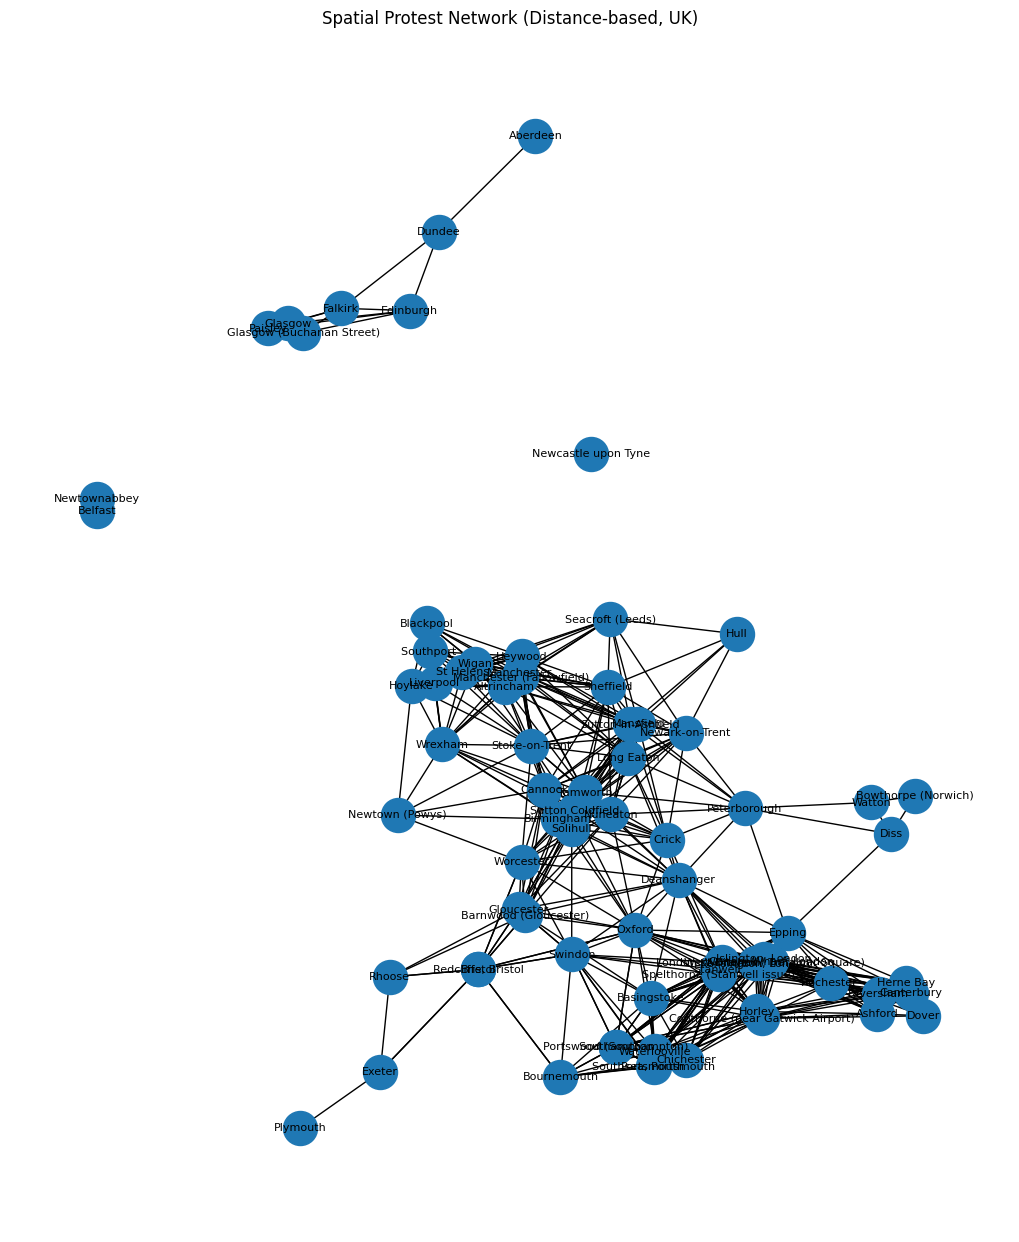

In [ ]:
plt.figure(figsize=(10, 12))

pos = {
    n: (G.nodes[n]["lon"], G.nodes[n]["lat"])
    for n in G.nodes()
}

nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=600,
    font_size=8
)

plt.title("Spatial Protest Network (Distance-based, UK)")
plt.show()

In [ ]:
!rm /content/LAD_MAY_2025_UK_BFC_V2_481919774574330966 (1).geojson

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `rm /content/LAD_MAY_2025_UK_BFC_V2_481919774574330966 (1).geojson'


In [ ]:
import geopandas as gpd

uk_map = gpd.read_file("/content/Local_Authority_Districts_May_2024_Boundaries_UK_BGC_-6307115499537197728.geojson")
uk_map.head()

,FID,LAD24CD,LAD24NM,LAD24NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,1,E06000001,Hartlepool,,447161,531473,-1.27017,54.67613,8d37e356-5471-457e-879d-d687d4dcd9b5,"MULTIPOLYGON (((-1.22459 54.62418, -1.22457 54..."
1,2,E06000002,Middlesbrough,,451141,516887,-1.21099,54.54467,30eaef71-04d1-4d40-a8da-8a4e2e7e0891,"MULTIPOLYGON (((-1.27712 54.54791, -1.2772 54...."
2,3,E06000003,Redcar and Cleveland,,464330,519596,-1.00656,54.56752,a345a607-6a7e-41bd-a268-81e3741ddc76,"MULTIPOLYGON (((-1.20098 54.57763, -1.20037 54..."
3,4,E06000004,Stockton-on-Tees,,444940,518179,-1.30664,54.55687,d1db01d0-100b-4619-b606-f1208ff4c8cb,"MULTIPOLYGON (((-1.27493 54.55187, -1.27546 54..."
4,5,E06000005,Darlington,,428029,515648,-1.56835,54.53534,c2cc315b-a5c5-497c-8aa4-2994a4d4820b,"POLYGON ((-1.43836 54.59508, -1.43807 54.59495..."


In [ ]:
!ls /content

'Copy support-local-authority-datasets-sep-2025.xlsx'
 Local_Authority_Districts_May_2024_Boundaries_UK_BGC_-6307115499537197728.geojson
 sample_data


In [ ]:
uk_map = uk_map.to_crs("EPSG:4326")

In [ ]:
from shapely.geometry import Point
import pandas as pd

city_df = pd.DataFrame({
    "city": list(G.nodes()),
    "latitude": [G.nodes[n]["lat"] for n in G.nodes()],
    "longitude": [G.nodes[n]["lon"] for n in G.nodes()]
})

geometry = [Point(xy) for xy in zip(city_df["longitude"], city_df["latitude"])]
city_gdf = gpd.GeoDataFrame(city_df, geometry=geometry, crs="EPSG:4326")

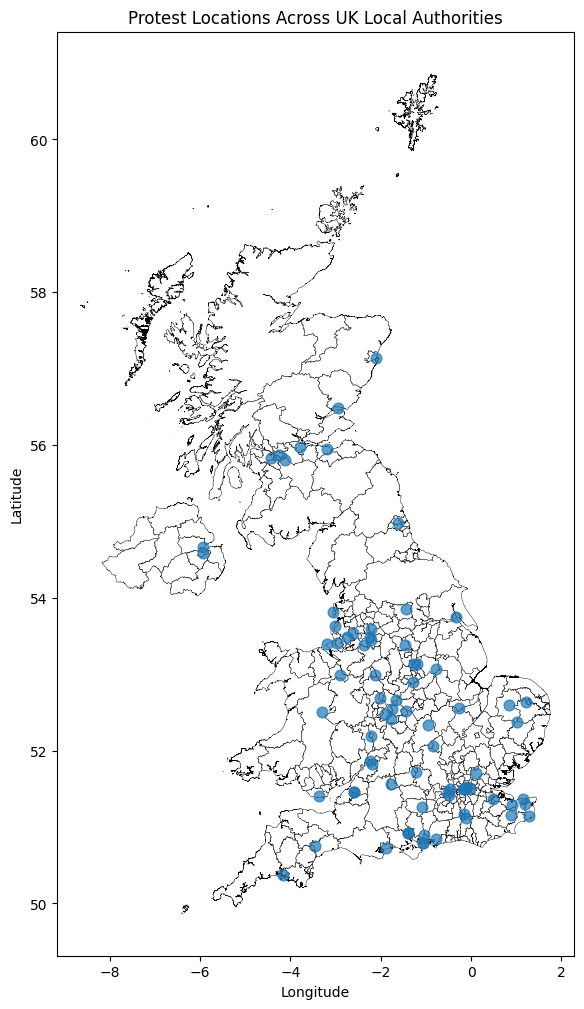

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 12))

# Plot local authority boundaries
uk_map.plot(
    ax=ax,
    color="white",
    edgecolor="black",
    linewidth=0.3
)

# Plot protest city points
city_gdf.plot(
    ax=ax,
    markersize=60,
    alpha=0.7
)

ax.set_title("Protest Locations Across UK Local Authorities")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

# Create geometry column from lat/lon
geometry = [Point(xy) for xy in zip(df["longitude"], df["latitude"])]

gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")


In [ ]:
uk_map = uk_map.to_crs(epsg=4326)

In [ ]:
gdf_with_la = gpd.sjoin(
    gdf,
    uk_map,
    how="left",
    predicate="within"
)

uk_map.columns

Index(['FID', 'LAD24CD', 'LAD24NM', 'LAD24NMW', 'BNG_E', 'BNG_N', 'LONG',
       'LAT', 'GlobalID', 'geometry'],
      dtype='object')

In [ ]:
gdf_with_la["local_authority"] = gdf_with_la["LAD24NM"]

In [ ]:
#gdf_with_la[["event_id", "town_city", "postcode", "local_authority", "LAD25CD"]].head()
protests_df = gdf_with_la[["event_id", "town_city", "postcode", "local_authority", "LAD24CD","date"]]

#rename the columns to make things easier later
protests_df = protests_df.rename(columns={
    "LAD24CD": "lad_code",
})

protests_df.head()

,event_id,town_city,postcode,local_authority,lad_code,date
0,U0011,Liverpool,L1 1JW,Liverpool,E08000012,2025-08-08
1,E0060,Aberdeen,AB10 1BL,Aberdeen City,S12000033,2025-09-06
2,E0036,Aberdeen,AB25 1XF,Aberdeen City,S12000033,2025-08-02
3,E0004,Birmingham,B1 1BD,Birmingham,E08000025,2025-05-17
4,E0048,Sutton Coldfield,B76 1LH,Birmingham,E08000025,2025-08-15


In [100]:
#in protests_df, how many times is each lad_code mentioned?
protests_df["lad_code"].value_counts()
#create a new df called protests_counts where the columns are local_authority values and rows are each assocaited event_id and date from protests_df
protests_counts = protests_df.groupby(["local_authority", "lad_code"]).size().reset_index(name="protests_count")
protests_counts
#sort table by count
protests_counts = protests_counts.sort_values(by="protests_count", ascending=False)
protests_counts

KeyError: 'la_counts'

In [89]:
#in protests_df, create quartiles out of the dates

#convert the date column
protests_df["date"] = pd.to_datetime(df["date"], errors="coerce")

#create proper quarterly time variable
protests_df["year_quarter"] = protests_df["date"].dt.to_period("Q")

#find counts of protests in each year_quarter
protests_df["year_quarter"].value_counts()

#find counts of the protests in each month
protests_df["date"].dt.month.value_counts()




,count
year_quarter,
2025Q3,104
2025Q4,17
2025Q2,5


In [92]:

temporal_counts = protests_df.groupby(["year_quarter"]).size().reset_index(name="protests_count")
temporal_counts

,year_quarter,protests_count
0,2025Q2,5
1,2025Q3,104
2,2025Q4,17


date,Q2,Q3,Q4,Apr,May,Jul,Aug,Sep,Oct,Nov
count,5,104,17,3,2,21,60,23,15,2


<Axes: xlabel='date'>

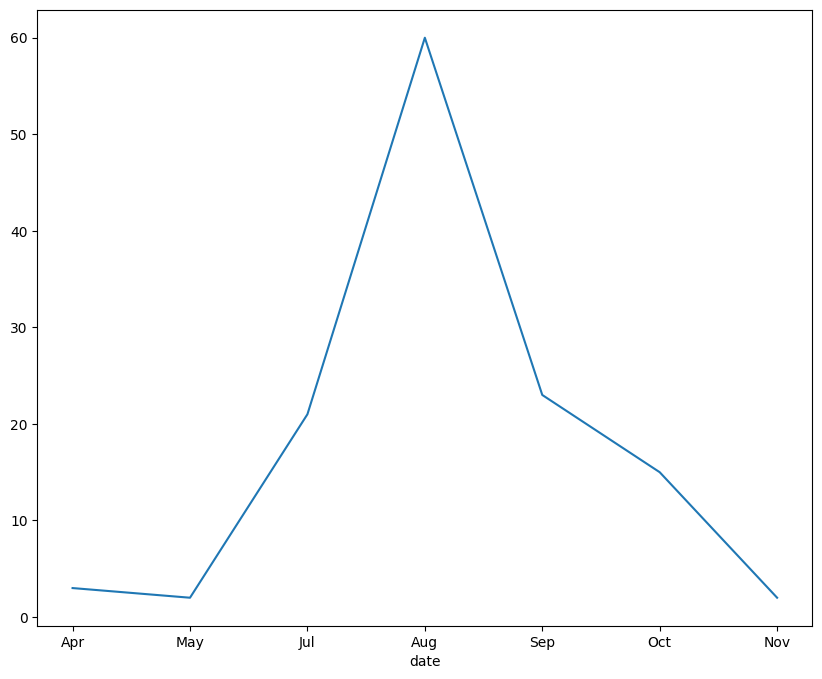

In [96]:
import calendar

# Calculate monthly protest counts
monthly_counts = protests_df["date"].dt.month.value_counts().sort_index()
monthly_counts.index = monthly_counts.index.map(lambda x: calendar.month_abbr[x])

# Calculate quarterly protest counts
# The temporal_counts DataFrame already has this, but let's re-process for clean quarter names
quarterly_counts = protests_df["date"].dt.quarter.value_counts().sort_index()
quarterly_counts.index = quarterly_counts.index.map(lambda x: f"Q{x}")

# Combine into a single Series for easy DataFrame creation
combined_counts = pd.concat([quarterly_counts, monthly_counts])

# Create a DataFrame from the combined Series, making it a single row
protest_summary_df = pd.DataFrame([combined_counts])

# Display the resulting DataFrame
display(protest_summary_df)

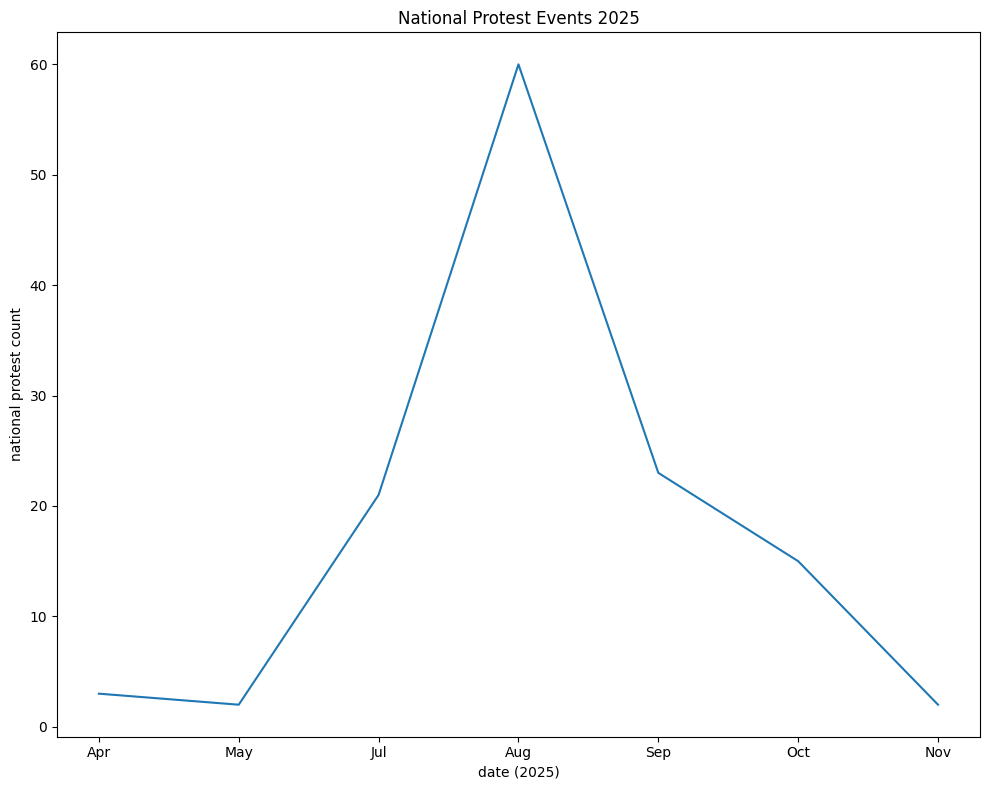

In [99]:
import matplotlib.pyplot as plt


#plot a line bar of the dataframe (x axis is months, y axis is protest counts)

monthly_counts.plot(kind="line")

plt.xlabel("date (2025)")
plt.ylabel("national protest count")
plt.title("National Protest Events 2025")

plt.tight_layout()
plt.show()

,count
date,
8,60
9,23
7,21
10,15
4,3
5,2
11,2


In [88]:
#plot monthly protests over time
protests_df["date"].dt.month



,date
0,8
1,9
2,8
3,5
4,8
...,...
121,8
122,9
123,8
124,8


In [ ]:
protests_df.dtypes

,0
event_id,object
town_city,object
postcode,object
local_authority,object
lad_code,object


In [ ]:

#change the data types accordingly so we can work with the data usign pandas
protests_df['event_id']=protests_df['event_id'].astype('string')
protests_df['town_city']=protests_df['town_city'].astype('category')
protests_df['postcode']=protests_df['postcode'].astype('category')
protests_df['local_authority']=protests_df['local_authority'].astype('category')

In [ ]:
import pandas as pd

pop_df = pd.read_excel(
    "/content/Copy support-local-authority-datasets-sep-2025.xlsx",
    sheet_name="population_per_LA",
    header=0,
    engine="openpyxl"
)
pop_df.head()

,lad_code,name,geography,population,Isy
0,E07000223,Adur,Non-metropolitan District,64889,True
1,E07000032,Amber Valley,Non-metropolitan District,130451,True
2,E07000224,Arun,Non-metropolitan District,170064,True
3,E07000170,Ashfield,Non-metropolitan District,129572,True
4,E07000105,Ashford,Non-metropolitan District,140936,True


In [ ]:
pop_df.columns
pop_df["lad_code"].nunique()


314

In [ ]:
la_exposure = pd.read_excel(
    "/content/Copy support-local-authority-datasets-sep-2025.xlsx",
    engine="openpyxl",
    sheet_name="la_exposure_table",
    header=0,
)
la_exposure.head()

,lad_code,local_authority,population,total_asylum,contingency_per_1000,contingency_share,delta_contingency_Q1_Q3
0,S12000033,Aberdeen City,NaN,624,NaN,0.083333,85.0
1,S12000033,Aberdeen City,NaN,624,NaN,0.533654,85.0
2,S12000034,Aberdeenshire,NaN,358,NaN,0.131285,82.0
3,S12000034,Aberdeenshire,NaN,358,NaN,0.796089,82.0
4,N09000001,Antrim and Newtownabbey,NaN,165,NaN,0.121212,-8.0


# Task
Merge the `uk_map` GeoDataFrame with the `protests_counts` DataFrame on `LAD24CD` and `lad_code` respectively, then fill any resulting `NaN` values in the `protests_count` column with `0`.

## Merge Protest Counts with Map Data

### Subtask:
Merge the `uk_map` GeoDataFrame with the `protests_counts` DataFrame based on the Local Authority codes (`LAD24CD` in `uk_map` and `lad_code` in `protests_counts`). This will add the `protests_count` to each local authority in the map data. After the merge, fill any `NaN` values in the `protests_count` column with `0`, as these indicate local authorities where no protests were recorded.


**Reasoning**:
To combine the geographical data with the protest counts, I will perform a left merge operation between the `uk_map` GeoDataFrame and the `protests_counts` DataFrame, using `LAD24CD` from `uk_map` and `lad_code` from `protests_counts` as the keys. Afterward, I'll fill any missing `protests_count` values with 0 to represent local authorities with no recorded protests.



In [104]:
uk_map = uk_map.merge(
    protests_counts,
    left_on="LAD24CD",
    right_on="lad_code",
    how="left"
)

uk_map["protests_count"] = uk_map["protests_count"].fillna(0)
uk_map.head()

,FID,LAD24CD,LAD24NM,LAD24NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry,local_authority,lad_code,protests_count
0,1,E06000001,Hartlepool,,447161,531473,-1.27017,54.67613,8d37e356-5471-457e-879d-d687d4dcd9b5,"MULTIPOLYGON (((-1.22459 54.62418, -1.22457 54...",NaN,NaN,0.0
1,2,E06000002,Middlesbrough,,451141,516887,-1.21099,54.54467,30eaef71-04d1-4d40-a8da-8a4e2e7e0891,"MULTIPOLYGON (((-1.27712 54.54791, -1.2772 54....",NaN,NaN,0.0
2,3,E06000003,Redcar and Cleveland,,464330,519596,-1.00656,54.56752,a345a607-6a7e-41bd-a268-81e3741ddc76,"MULTIPOLYGON (((-1.20098 54.57763, -1.20037 54...",NaN,NaN,0.0
3,4,E06000004,Stockton-on-Tees,,444940,518179,-1.30664,54.55687,d1db01d0-100b-4619-b606-f1208ff4c8cb,"MULTIPOLYGON (((-1.27493 54.55187, -1.27546 54...",NaN,NaN,0.0
4,5,E06000005,Darlington,,428029,515648,-1.56835,54.53534,c2cc315b-a5c5-497c-8aa4-2994a4d4820b,"POLYGON ((-1.43836 54.59508, -1.43807 54.59495...",NaN,NaN,0.0


## Final Task

### Subtask:
Review the merged GeoDataFrame to ensure that each Local Authority now has an associated `protests_count`, with `NaN` values correctly filled, and is ready for visualization.


## Summary:

### Data Analysis Key Findings

*   The `uk_map` GeoDataFrame was successfully merged with the `protests_counts` DataFrame, enriching the geographical data with protest statistics.
*   A new `protests_count` column was added to the `uk_map` GeoDataFrame, containing the number of protests for each Local Authority.
*   All missing (`NaN`) values in the `protests_count` column were successfully replaced with `0`, indicating that these local authorities had no recorded protests.

### Insights or Next Steps

*   The merged GeoDataFrame, with protest counts correctly assigned and `NaN` values handled, is now prepared for geographical visualization to highlight protest distribution across UK local authorities.
*   Further analysis can explore the spatial patterns of protest activities, potentially identifying regions with higher or lower frequencies of protests.


# Task
Calculate the centroid for the geometry of each Local Authority in the `uk_map` GeoDataFrame. These centroids will be used as the location for placing markers on the map, with their sizes representing the protest counts. Then, generate a plot displaying the UK map with Local Authority boundaries, overlaying markers at the calculated centroids, where the size of each marker is proportional to the `protests_count` for that Local Authority. Ensure a legend is included to explain the varying marker sizes, and add a title and axis labels to the plot. Finally, review the generated map to ensure it effectively visualizes the volume of protests across different Local Authorities using centroid sizes, and summarize the key insights from the visualization.

## Calculate Centroids

### Subtask:
Calculate the centroid for the geometry of each Local Authority in the `uk_map` GeoDataFrame. These centroids will be used as the location for placing markers on the map, with their sizes representing the protest counts.


**Reasoning**:
To calculate the centroids for each local authority's geometry, I will apply the 'centroid' property to the 'geometry' column in the `uk_map` GeoDataFrame, then extract the x and y coordinates into separate 'longitude_centroid' and 'latitude_centroid' columns respectively.



In [105]:
uk_map["centroid"] = uk_map["geometry"].centroid
uk_map["longitude_centroid"] = uk_map["centroid"].x
uk_map["latitude_centroid"] = uk_map["centroid"].y

uk_map.head()

/tmp/ipython-input-3329880521.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  uk_map["centroid"] = uk_map["geometry"].centroid


,FID,LAD24CD,LAD24NM,LAD24NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry,local_authority,lad_code,protests_count,centroid,longitude_centroid,latitude_centroid
0,1,E06000001,Hartlepool,,447161,531473,-1.27017,54.67613,8d37e356-5471-457e-879d-d687d4dcd9b5,"MULTIPOLYGON (((-1.22459 54.62418, -1.22457 54...",NaN,NaN,0.0,POINT (-1.25925 54.66942),-1.259250,54.669423
1,2,E06000002,Middlesbrough,,451141,516887,-1.21099,54.54467,30eaef71-04d1-4d40-a8da-8a4e2e7e0891,"MULTIPOLYGON (((-1.27712 54.54791, -1.2772 54....",NaN,NaN,0.0,POINT (-1.22229 54.54202),-1.222288,54.542020
2,3,E06000003,Redcar and Cleveland,,464330,519596,-1.00656,54.56752,a345a607-6a7e-41bd-a268-81e3741ddc76,"MULTIPOLYGON (((-1.20098 54.57763, -1.20037 54...",NaN,NaN,0.0,POINT (-1.02074 54.55169),-1.020742,54.551691
3,4,E06000004,Stockton-on-Tees,,444940,518179,-1.30664,54.55687,d1db01d0-100b-4619-b606-f1208ff4c8cb,"MULTIPOLYGON (((-1.27493 54.55187, -1.27546 54...",NaN,NaN,0.0,POINT (-1.3323 54.56163),-1.332299,54.561631
4,5,E06000005,Darlington,,428029,515648,-1.56835,54.53534,c2cc315b-a5c5-497c-8aa4-2994a4d4820b,"POLYGON ((-1.43836 54.59508, -1.43807 54.59495...",NaN,NaN,0.0,POINT (-1.55265 54.54872),-1.552652,54.548719


**Reasoning**:
The previous code generated a `UserWarning` regarding centroid calculation on a geographic CRS, which can lead to incorrect results. To address this, I need to re-project the `uk_map` GeoDataFrame to a suitable projected CRS (EPSG:27700 for UK) before calculating the centroids, and then re-project the centroids back to EPSG:4326 for consistency with latitude/longitude values.



In [106]:
uk_map_proj = uk_map.to_crs(epsg=27700)
uk_map_proj["centroid_proj"] = uk_map_proj["geometry"].centroid
uk_map["centroid"] = uk_map_proj["centroid_proj"].to_crs(epsg=4326)

uk_map["longitude_centroid"] = uk_map["centroid"].x
uk_map["latitude_centroid"] = uk_map["centroid"].y

uk_map.head()

,FID,LAD24CD,LAD24NM,LAD24NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry,local_authority,lad_code,protests_count,centroid,longitude_centroid,latitude_centroid
0,1,E06000001,Hartlepool,,447161,531473,-1.27017,54.67613,8d37e356-5471-457e-879d-d687d4dcd9b5,"MULTIPOLYGON (((-1.22459 54.62418, -1.22457 54...",NaN,NaN,0.0,POINT (-1.25925 54.66942),-1.259248,54.669415
1,2,E06000002,Middlesbrough,,451141,516887,-1.21099,54.54467,30eaef71-04d1-4d40-a8da-8a4e2e7e0891,"MULTIPOLYGON (((-1.27712 54.54791, -1.2772 54....",NaN,NaN,0.0,POINT (-1.22228 54.54201),-1.222279,54.542012
2,3,E06000003,Redcar and Cleveland,,464330,519596,-1.00656,54.56752,a345a607-6a7e-41bd-a268-81e3741ddc76,"MULTIPOLYGON (((-1.20098 54.57763, -1.20037 54...",NaN,NaN,0.0,POINT (-1.02069 54.5517),-1.020685,54.551704
3,4,E06000004,Stockton-on-Tees,,444940,518179,-1.30664,54.55687,d1db01d0-100b-4619-b606-f1208ff4c8cb,"MULTIPOLYGON (((-1.27493 54.55187, -1.27546 54...",NaN,NaN,0.0,POINT (-1.33233 54.5616),-1.332334,54.561596
4,5,E06000005,Darlington,,428029,515648,-1.56835,54.53534,c2cc315b-a5c5-497c-8aa4-2994a4d4820b,"POLYGON ((-1.43836 54.59508, -1.43807 54.59495...",NaN,NaN,0.0,POINT (-1.55261 54.54871),-1.552610,54.548713


**Reasoning**:
To visualize the protest counts on the UK map, I will create a base map using `uk_map` and then overlay scatter points at the calculated centroids, sizing these points proportionally to the `protests_count`. I will also add a legend for marker sizes, a title, and axis labels for clarity.



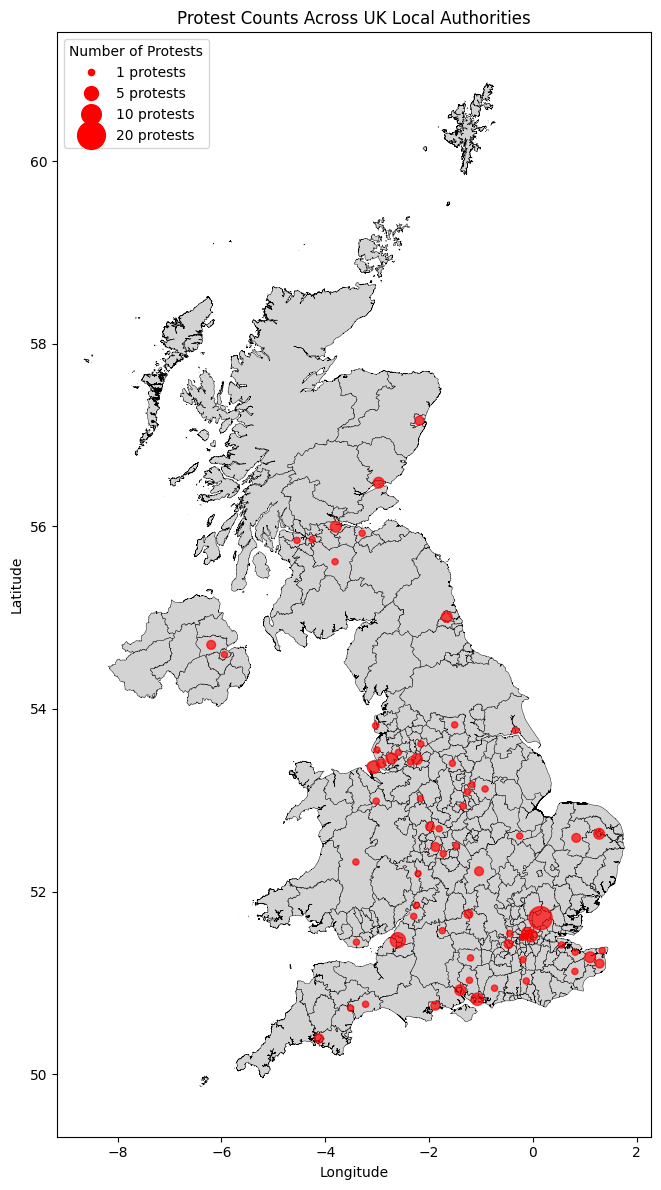

In [107]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Plot the UK map with local authority boundaries
uk_map.plot(
    ax=ax,
    color='lightgray',
    edgecolor='black',
    linewidth=0.3
)

# Plot centroids with size proportional to protests_count
scatter = ax.scatter(
    uk_map['longitude_centroid'],
    uk_map['latitude_centroid'],
    s=uk_map['protests_count'] * 20, # Scale marker size for visibility
    alpha=0.7,
    color='red',
    label='Protest Count'
)

# Create a custom legend for marker sizes
handles = []
labels = []
for size_val in [1, 5, 10, 20]: # Example sizes for legend
    handles.append(plt.Line2D([0], [0], marker='o', color='r', markersize=np.sqrt(size_val * 20), label=f'{size_val} protests', linestyle=''))
    labels.append(f'{size_val} protests')

ax.legend(handles, labels, title='Number of Protests', loc='upper left')

ax.set_title('Protest Counts Across UK Local Authorities')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.tight_layout()
plt.show()


## Summary:

### Visualization Key Findings
*   The map successfully visualizes the `protests_count` for each Local Authority by using proportionally sized markers at their centroids.
*   Areas with higher protest counts are clearly indicated by larger red markers, providing an immediate visual understanding of protest hotspots.
*   The legend effectively explains the mapping between marker size and the number of protests.

### Insights or Next Steps
*   The map provides a clear geographical overview of protest activity, allowing for quick identification of regions with significant protest volumes.
*   Further analysis could involve correlating protest counts with other demographic or socioeconomic factors within these local authorities to understand underlying causes or patterns.
*   The visualization is ready for presentation or further integration into a dashboard.

## Final Task

### Subtask:
Review the generated map to ensure it effectively visualizes the volume of protests across different Local Authorities using centroid sizes, and summarize the key insights from the visualization.


## Summary:

### Q&A
The generated map effectively visualizes the volume of protests across different Local Authorities by using proportionally sized markers at their centroids. This approach allows for clear identification of protest hotspots, as areas with higher protest counts are represented by larger red markers. The accompanying legend effectively clarifies the relationship between marker size and the number of protests, making the visualization easy to interpret.

### Data Analysis Key Findings
*   Initial centroid calculations performed directly on the geographic Coordinate Reference System (CRS) of the `uk_map` GeoDataFrame resulted in a warning, indicating potential inaccuracies.
*   Accurate centroids were successfully calculated by re-projecting the `uk_map` GeoDataFrame to a projected CRS (EPSG:27700), calculating centroids in this system, and then re-projecting them back to a geographic CRS (EPSG:4326).
*   The `uk_map` GeoDataFrame was updated to include new `centroid` geometry, `longitude_centroid`, and `latitude_centroid` columns.
*   A geographical plot was successfully generated, displaying UK local authority boundaries with red circular markers at the calculated centroids. The size of these markers was scaled by a factor of 20 relative to the `protests_count`, effectively highlighting protest volumes.
*   The visualization includes a legend that explains marker sizes for 1, 5, 10, and 20 protests, a clear title "Protest Counts Across UK Local Authorities," and appropriate axis labels.

### Insights or Next Steps
*   The visualization offers a clear geographical overview of protest activity, enabling rapid identification of regions with significant protest volumes.
*   Further analysis could explore correlations between protest counts and other demographic or socioeconomic factors within these Local Authorities to understand underlying patterns or causes.
